# Agent-based Transportaion Model

Let's create a simple agent-based transportation model. First, start with a transportation network. Our transportation network can be created as a Networkx Graph or a (Geo)Pandas (Geo)DataFrame. There are some sample transportation networks available in dpd.mapping.samples. Real-life networks can be imported from OpenStreetMap via pyrosm.

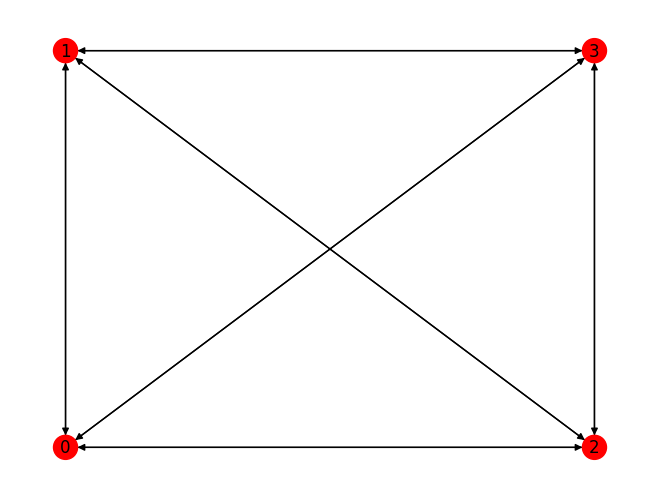

In [1]:
from networkx import draw

from dpd.mapping.samples import cross_box

graph = cross_box

pos = {
    node: (graph.nodes()[node]["geometry"].x, graph.nodes()[node]["geometry"].y)
    for node in graph.nodes
}

node_color = [
    (
        "red"
        if graph.nodes()[node].get("type") == "stop_sign"
        else (
            "yellow"
            if graph.nodes()[node].get("type") == "yield_sign"
            else (
                "blue"
                if graph.nodes()[node].get("type") == "stop_light"
                else "orange" if graph.nodes()[node].get("type") == "stop" else "green"
            )
        )
    )
    for node in graph.nodes()
]

draw(graph, pos=pos, node_color=node_color, with_labels=True)

<Axes: >

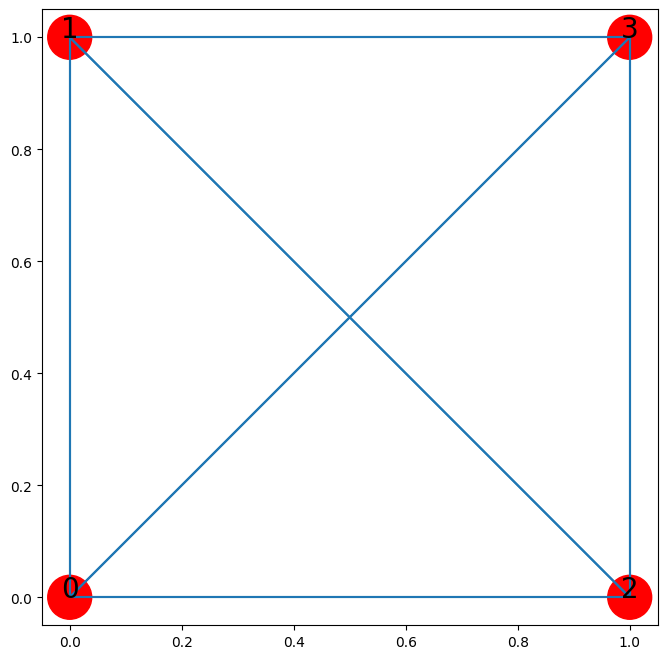

In [2]:
from geopandas import GeoDataFrame
from matplotlib import pyplot as plt

edges_df = GeoDataFrame(
    [graph.edges[edge] for edge in graph.edges], index=list(graph.edges)
)
nodes_df = GeoDataFrame([graph.nodes[node] for node in graph.nodes])

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111)

nodes_df["geometry"].plot(ax=ax, color=node_color, markersize=1000)
nodes_df.apply(
    lambda x: ax.annotate(text=x.name, xy=x.geometry.coords[0], ha="center", size=20),
    axis=1,
)
edges_df["geometry"].plot(ax=ax)

Next, we need to tranform our transportation network in to Python objects for Edges and Nodes. Again, this can be done with either a Graph or a (Geo)DataFrame.

In [3]:
from dpd.mapping import add_object_to_edges_and_nodes

graph = add_object_to_edges_and_nodes(graph)

In [4]:
from dpd.mapping.edges import object_for_edge
from dpd.mapping.nodes import object_for_node

edges_df["object"] = edges_df.apply(object_for_edge, axis=1)
nodes_df["object"] = nodes_df.apply(object_for_node, axis=1)

networkx provides the ability to compute a path from any node to another node. When using OpenStreetMap, the same can be accomplished via the Open Source Routing Machine.

In [5]:
from networkx import shortest_path

node_ids = shortest_path(graph, 0, 1)
print("Node IDs:", node_ids)

Node IDs: [0, 1]


To create a couple agents, we can create some transportation zones. For simplicity, we will create one zone per node with three Production and three Attraction so each zone has one person that goes to each other zone. Below are some other DataFrames we can generate from the Zones DataFrame. Also, we will create a path for each person using networkx.

In [6]:
from dpd.modeling import Zones

zones = Zones(
    data=[
        {"Name": "Zone 0", "Production": 3, "Attraction": 3},
        {"Name": "Zone 1", "Production": 3, "Attraction": 3},
        {"Name": "Zone 2", "Production": 3, "Attraction": 3},
        {"Name": "Zone 3", "Production": 3, "Attraction": 3},
    ],
    index=nodes_df.index,
)
zones["geometry"] = nodes_df["geometry"]
zones

/var/folders/r4/0h9hr9rd7gx0k7mb58t92vcm0000gn/T/ipykernel_39551/4029771013.py:12: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  zones["geometry"] = nodes_df["geometry"]


,Name,Production,Attraction,geometry
0,Zone 0,1,1,POINT (0.00000 0.00000)
1,Zone 1,1,1,POINT (0.00000 1.00000)
2,Zone 2,1,1,POINT (1.00000 0.00000)
3,Zone 3,1,1,POINT (1.00000 1.00000)


In [7]:
distance_dataframe = zones.calculate_distance_dataframe()
distance_dataframe

,0,1,2,3
0,0.000000,111195.080234,111195.080234,157249.598474
1,111195.080234,0.000000,157249.598474,111195.080234
2,111195.080234,157249.598474,0.000000,111178.144254
3,157249.598474,111195.080234,111178.144254,0.000000


In [8]:
import numpy

from dpd.modeling import TripDataFrame

trip_dataframe = TripDataFrame(
    data=numpy.ones([4, 4]), index=zones.index, columns=zones.index
).map(int)

trip_dataframe

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1


In [9]:
from dpd.modeling import Population

population = Population.from_trip_dataframe(trip_dataframe)
population = population[
    population.origin != population.destination
]  # remove rows where the origin and destination zone are equal
population

,origin,destination
1,0,1
2,0,2
3,0,3
4,1,0
6,1,2
7,1,3
8,2,0
9,2,1
11,2,3
12,3,0


In [10]:
population["node_ids"] = population.apply(
    lambda x: shortest_path(graph, x["origin"], x["destination"]), axis=1
)
population

,origin,destination,node_ids
1,0,1,"[0, 1]"
2,0,2,"[0, 2]"
3,0,3,"[0, 3]"
4,1,0,"[1, 0]"
6,1,2,"[1, 2]"
7,1,3,"[1, 3]"
8,2,0,"[2, 0]"
9,2,1,"[2, 1]"
11,2,3,"[2, 3]"
12,3,0,"[3, 0]"


Next, we setup and run our agent-based model.

In [104]:
from uuid import uuid4

from dpd.driving import EdgesLanesNodesDriver
from dpd.mapping.nodes import StopSign
from dpd.mechanics import KinematicBodyWithAcceleration
from dpd.modeling import TransportationModel

body_model = TransportationModel(
    agent_reporters={"position": "position"} | {"geometry": "geometry"}
)

node_model = TransportationModel()

for node_id in graph.nodes:
    node = graph.nodes[node_id]["object"]
    if type(node) == StopSign:
        node.model = node_model
        node.unique_id = uuid4()
        node.entry_velocity = 0
        node_model.schedule.add(node)

for index, row in population.iterrows():
    kbwas = KinematicBodyWithAcceleration(
        initial_acceleration=0.1,
        initial_velocity=0.1,
        initial_position=0,
        max_deceleration=0.1,
        min_velocity=0,
        unique_id=uuid4(),
        model=body_model,
    )
    elnd = EdgesLanesNodesDriver.from_node_ids(
        nodes_dict=graph.nodes,
        edges_dict=graph.edges,
        node_ids=row["node_ids"],
        body=kbwas,
        driver_final_velocity=0,
        unique_id=uuid4(),
        model=body_model,
    )
    body_model.schedule.add(elnd)

while body_model.running:
    body_model.step()
    node_model.step()

df = GeoDataFrame(body_model.get_dataframe())
df

position                 geometry  \
Step AgentID                                                                   
0    ede984a5-7a7d-4a6c-b6a0-9233e7697e50  0.000000  POINT (0.00000 0.00000)   
     2305dc9e-bf10-4e2e-8efa-70146384329d  0.000000  POINT (0.00000 0.00000)   
     0fea69b7-dd78-44c1-829d-4821367cf027  0.000000  POINT (0.00000 0.00000)   
     096d22aa-580f-4096-bc03-0d4f29ad84fa  0.000000  POINT (0.00000 1.00000)   
     9b5dcd62-9c1e-40b7-bf28-7908bc873389  0.000000  POINT (0.00000 1.00000)   
     719b8542-e449-46a6-ab60-a747fefd131d  0.000000  POINT (0.00000 1.00000)   
     a9afa333-44b5-4629-a7fa-c49f106822c9  0.000000  POINT (1.00000 0.00000)   
     afc5ad0e-d15d-40bb-be8e-d8802848a532  0.000000  POINT (1.00000 0.00000)   
     d509e9e8-ab62-48ac-818c-93694679fd32  0.000000  POINT (1.00000 0.00000)   
     45f1e0da-77b0-4725-be0c-faf4d5149057  0.000000  POINT (1.00000 1.00000)   
     3ef426d0-b12d-40ac-a0b4-2c3d932531cd  0.000000  POINT (1.00000 1.00000)   
     fd4d6bab-f42d-49ea-9054-5b7ea4a4ed64  0.000000  POINT (1.00000 1.00000)   
1    ede984a5-7a7d-4a6c-b6a0-9233e7697e50  0.200000  POINT (0.00000 0.20000)   
     2305dc9e-bf10-4e2e-8efa-70146384329d  0.200000  POINT (0.20000 0.00000)   
     0fea69b7-dd78-44c1-829d-4821367cf027  0.200000  POINT (0.14142 0.14142)   
     096d22aa-580f-4096-bc03-0d4f29ad84fa  0.200000  POINT (0.00000 0.80000)   
     9b5dcd62-9c1e-40b7-bf28-7908bc873389  0.200000  POINT (0.14142 0.85858)   
     719b8542-e449-46a6-ab60-a747fefd131d  0.200000  POINT (0.20000 1.00000)   
     a9afa333-44b5-4629-a7fa-c49f106822c9  0.200000  POINT (0.80000 0.00000)   
     afc5ad0e-d15d-40bb-be8e-d8802848a532  0.200000  POINT (0.85858 0.14142)   
     d509e9e8-ab62-48ac-818c-93694679fd32  0.200000  POINT (1.00000 0.20000)   
     45f1e0da-77b0-4725-be0c-faf4d5149057  0.200000  POINT (0.85858 0.85858)   
     3ef426d0-b12d-40ac-a0b4-2c3d932531cd  0.200000  POINT (0.80000 1.00000)   
     fd4d6bab-f42d-49ea-9054-5b7ea4a4ed64  0.200000  POINT (1.00000 0.80000)   
2    ede984a5-7a7d-4a6c-b6a0-9233e7697e50  0.500000  POINT (0.00000 0.50000)   
     2305dc9e-bf10-4e2e-8efa-70146384329d  0.500000  POINT (0.50000 0.00000)   
     0fea69b7-dd78-44c1-829d-4821367cf027  0.500000  POINT (0.35355 0.35355)   
     096d22aa-580f-4096-bc03-0d4f29ad84fa  0.500000  POINT (0.00000 0.50000)   
     9b5dcd62-9c1e-40b7-bf28-7908bc873389  0.500000  POINT (0.35355 0.64645)   
     719b8542-e449-46a6-ab60-a747fefd131d  0.500000  POINT (0.50000 1.00000)   
     a9afa333-44b5-4629-a7fa-c49f106822c9  0.500000  POINT (0.50000 0.00000)   
     afc5ad0e-d15d-40bb-be8e-d8802848a532  0.500000  POINT (0.64645 0.35355)   
     d509e9e8-ab62-48ac-818c-93694679fd32  0.500000  POINT (1.00000 0.50000)   
     45f1e0da-77b0-4725-be0c-faf4d5149057  0.500000  POINT (0.64645 0.64645)   
     3ef426d0-b12d-40ac-a0b4-2c3d932531cd  0.500000  POINT (0.50000 1.00000)   
     fd4d6bab-f42d-49ea-9054-5b7ea4a4ed64  0.500000  POINT (1.00000 0.50000)   
3    ede984a5-7a7d-4a6c-b6a0-9233e7697e50  0.816228  POINT (0.00000 0.81623)   
     2305dc9e-bf10-4e2e-8efa-70146384329d  0.816228  POINT (0.81623 0.00000)   
     0fea69b7-dd78-44c1-829d-4821367cf027  0.900000  POINT (0.63640 0.63640)   
     096d22aa-580f-4096-bc03-0d4f29ad84fa  0.816228  POINT (0.00000 0.18377)   
     9b5dcd62-9c1e-40b7-bf28-7908bc873389  0.900000  POINT (0.63640 0.36360)   
     719b8542-e449-46a6-ab60-a747fefd131d  0.816228  POINT (0.81623 1.00000)   
     a9afa333-44b5-4629-a7fa-c49f106822c9  0.816228  POINT (0.18377 0.00000)   
     afc5ad0e-d15d-40bb-be8e-d8802848a532  0.900000  POINT (0.36360 0.63640)   
     d509e9e8-ab62-48ac-818c-93694679fd32  0.816228  POINT (1.00000 0.81623)   
     45f1e0da-77b0-4725-be0c-faf4d5149057  0.900000  POINT (0.36360 0.36360)   
     3ef426d0-b12d-40ac-a0b4-2c3d932531cd  0.816228  POINT (0.18377 1.00000)   
     fd4d6bab-f42d-49ea-9054-5b7ea4a4ed64  0.816228  POINT (1.00000 0.18377)   
4    0fea69b7-dd78-44c1-829d-4821367cf027  

In [105]:
from datetime import datetime

from geopandas import GeoDataFrame
from movingpandas import TrajectoryCollection
from pandas import to_timedelta

START_TIME = datetime(1970, 1, 1, 0, 0, 0)
timedelta = to_timedelta(df.index.levels[0], unit="s")
index = START_TIME + timedelta
gdf = df
gdf.index = gdf.index.set_levels(index, level=0)
gdf.reset_index(level="AgentID", inplace=True)
tc = TrajectoryCollection(gdf, "AgentID")
tc.add_speed()
tc.hvplot(line_width=10)

/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: Mis

/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/movingpandas/trajectory.py:166: Mis

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Path.I      :Path   [Longitude,Latitude]
   .Path.II     :Path   [Longitude,Latitude]
   .Path.III    :Path   [Longitude,Latitude]
   .Path.IV     :Path   [Longitude,Latitude]
   .Path.V      :Path   [Longitude,Latitude]
   .Path.VI     :Path   [Longitude,Latitude]
   .Path.VII    :Path   [Longitude,Latitude]
   .Path.VIII   :Path   [Longitude,Latitude]
   .Path.IX     :Path   [Longitude,Latitude]
   .Path.X      :Path   [Longitude,Latitude]
   .Path.XI     :Path   [Longitude,Latitude]
   .Path.XII    :Path   [Longitude,Latitude]
   .Points.I    :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.III  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.IV   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.V    :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.VI   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.VII  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.VIII :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.IX   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.X    :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.XI   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.XII  :Points   [Longitude,Latitude]   (triangle_angle)

In [113]:
import random


def random_color():
    return (
        "#"
        + hex(random.randint(0, 0xFF))[2:]
        + hex(random.randint(0, 0xFF))[2:]
        + hex(random.randint(0, 0xFF))[2:]
    )


features = []
for trajectory in tc.trajectories:
    color = random_color()
    df = trajectory.df.copy()
    df["previous_geometry"] = df["geometry"].shift()
    df["time"] = df.index
    df["previous_time"] = df["time"].shift()
    for _, row in df.iloc[1:].iterrows():
        coordinates = [
            [row["previous_geometry"].xy[0][0], row["previous_geometry"].xy[1][0]],
            [row["geometry"].xy[0][0], row["geometry"].xy[1][0]],
        ]
        times = [row["previous_time"].isoformat(), row["time"].isoformat()]
        features.append(
            {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": coordinates,
                },
                "properties": {
                    "times": times,
                    "style": {
                        "color": color,
                        "weight": 5,
                    },
                },
            }
        )

import folium
from folium.plugins import TimestampedGeoJson

m = folium.Map(location=[38.913340600000055, -77.009092], zoom_start=16)

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="PT1S",
    add_last_point=True,
    transition_time=1000,
).add_to(m)

m